<a href="https://colab.research.google.com/github/imadahmad97/garbage-image-classifier/blob/main/model/CNN_2_MoreData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA 608 - Final Project ML Model
## Garbage Classification ML Model: CNN

>__Group Members__
* Ibtassam Rasheed (30201479)
* Imad Ahmad (30198988)
* Jose Palacios (30190988)
* Onur Taylan Cicek (30184538)

In [ ]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Input, Dropout
from keras.optimizers import Adam
from keras.metrics import Accuracy
from keras.models import load_model
from keras.utils import np_utils
from matplotlib import pyplot as plt
import os
import cv2
import imghdr
import numpy as np
from zipfile import ZipFile
import warnings
from google.colab import files
import shutil
warnings.filterwarnings('ignore')

## GPU Allocation

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
shutil.copy('/content/drive/MyDrive/Data608_Project/garbage_classification.zip', '/content/garbage-classification.zip')

'/content/garbage-classification.zip'

In [ ]:
file_name = "/content/garbage-classification.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()

In [ ]:
dir = "/content/garbage_classification/"
trash_list = ['trash', 'clothes', 'battery', 'shoes']
recyc_list = ['plastic', 'brown-glass', 'white-glass', 'cans', 'cardboard', 'coffee-mugs', 'green-glass', 'metal', 'paper']
comp_list = ['biological']
for folder in os.listdir(dir):
  if folder in trash_list:
    dir_path = dir + 'trash/'
    if not os.path.exists(dir_path):
      os.makedirs(dir_path)
    for f in os.listdir(dir+folder):
      shutil.move(dir + folder + '/' + f, dir_path + f)
  elif folder in recyc_list:
    dir_path = dir + 'recyc/'
    if not os.path.exists(dir_path):
      os.makedirs(dir_path)
    for f in os.listdir(dir+folder):
      shutil.move(dir + folder + '/' + f, dir_path + f)
  elif folder in comp_list:
    dir_path = dir + 'comp/'
    if not os.path.exists(dir_path):
      os.makedirs(dir_path)
    for f in os.listdir(dir+folder):
      shutil.move(dir + folder + '/' + f, dir_path + f)

for folder in os.listdir(dir):
  if folder not in ['trash', 'recyc', 'comp']:
    os.rmdir(dir + folder)
  else:
    path = dir + folder + '/'
    for file in os.listdir(path):
        if file.endswith('.jpg') or file.endswith('.JPG'):
            img = cv2.imread(path+str(file))
            cv2.imwrite(path+file[0:-4]+'.jpeg', img)
            os.remove(path+file)

In [ ]:
num_class = len(list(os.listdir(dir)))
print(f'There are {num_class} classes to classify')

There are 3 classes to classify


## Loading Data

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('/content/garbage_classification')
data = data.map(lambda x,y: (int(x), y))
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

Found 16234 files belonging to 3 classes.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


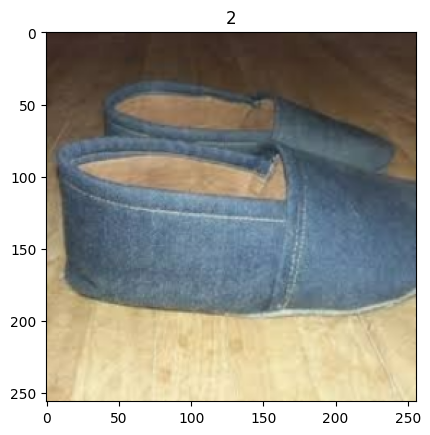

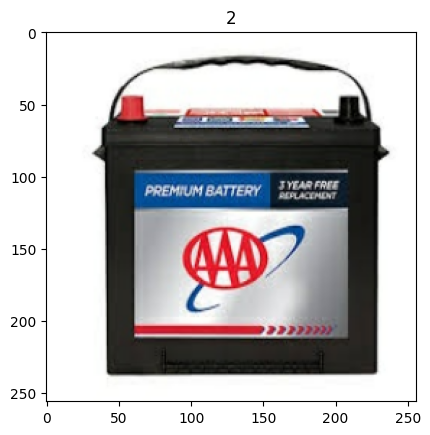

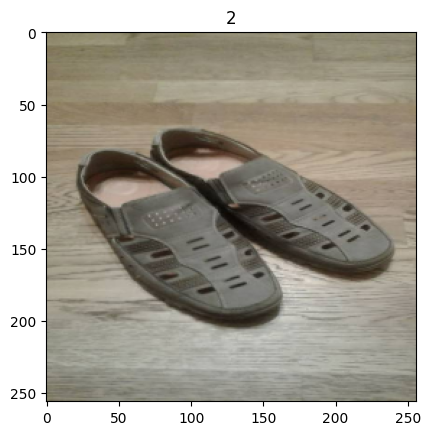

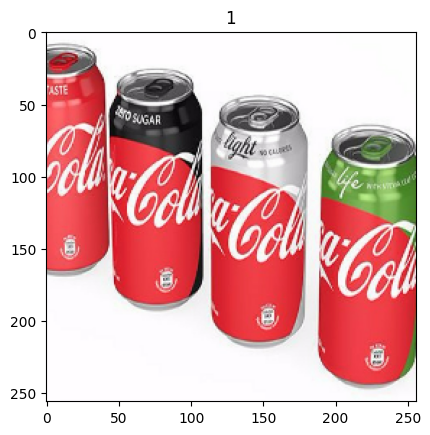

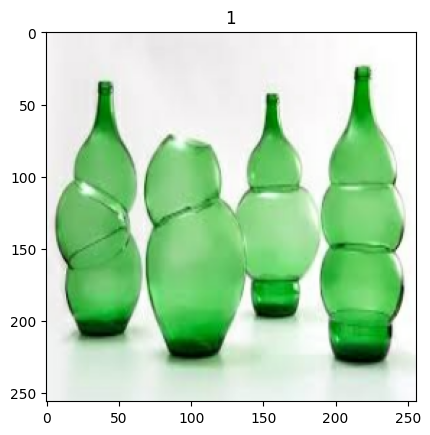

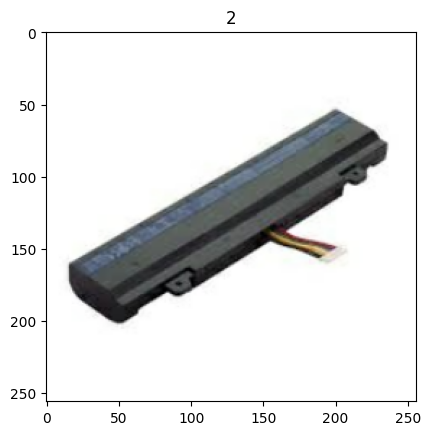

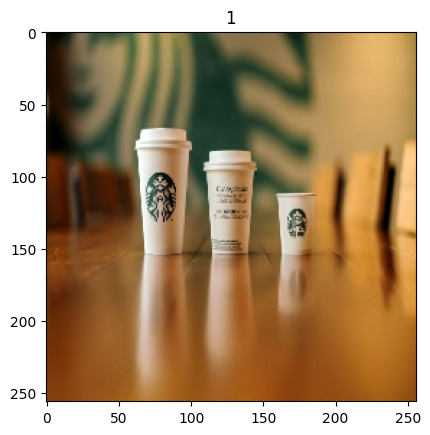

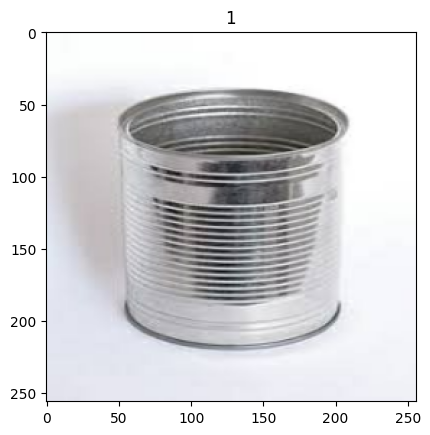

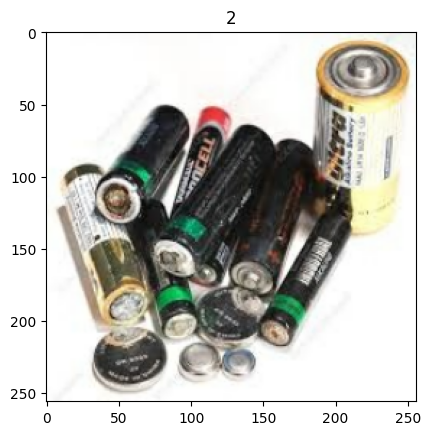

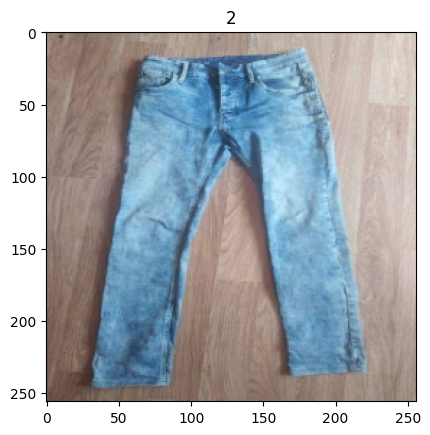

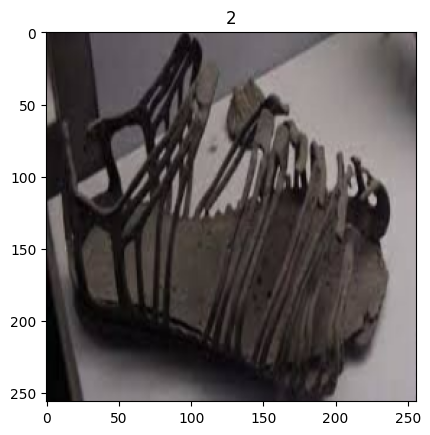

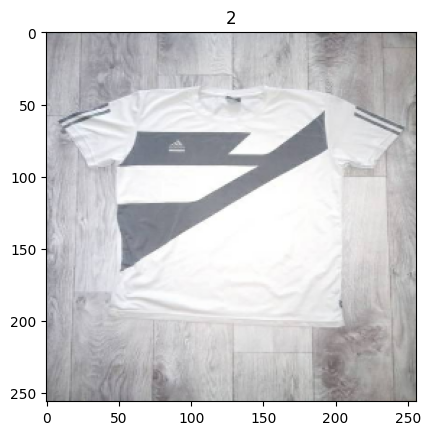

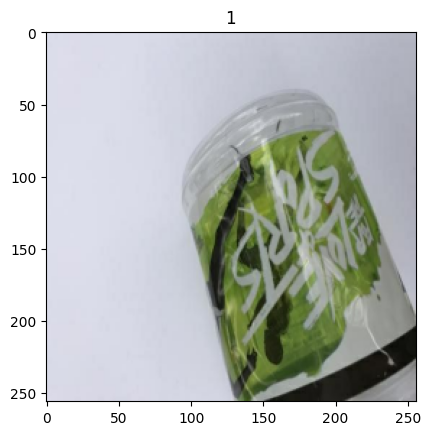

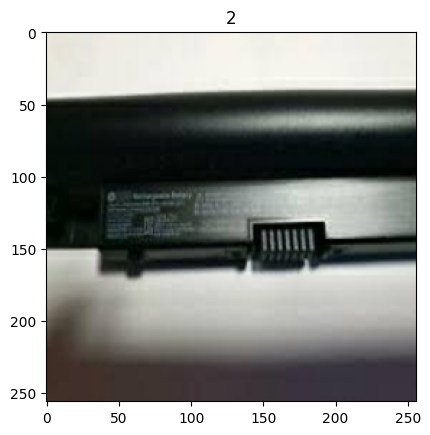

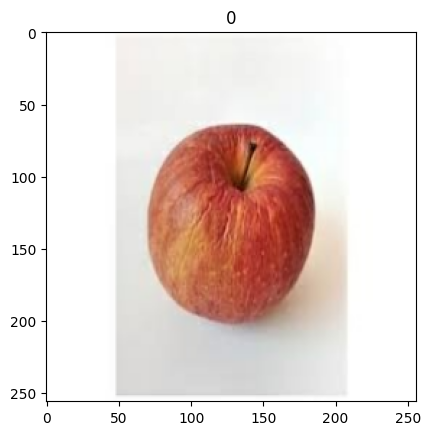

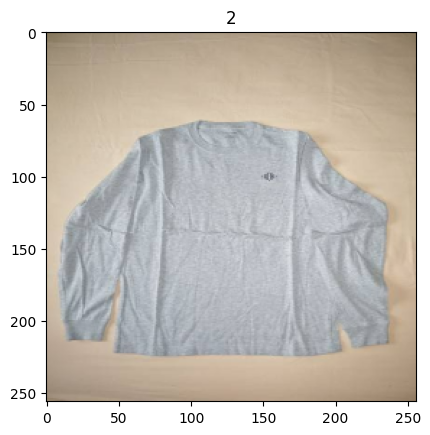

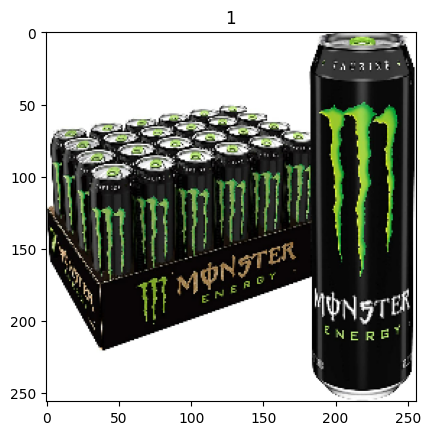

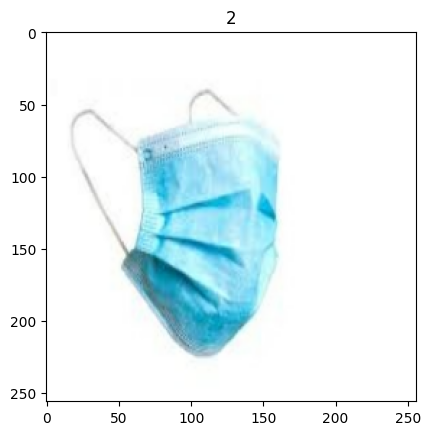

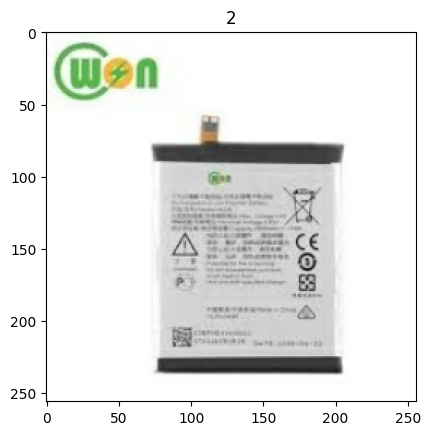

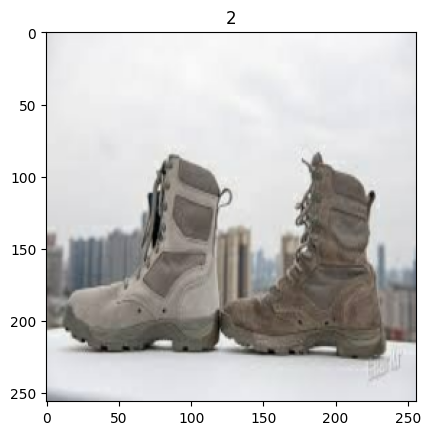

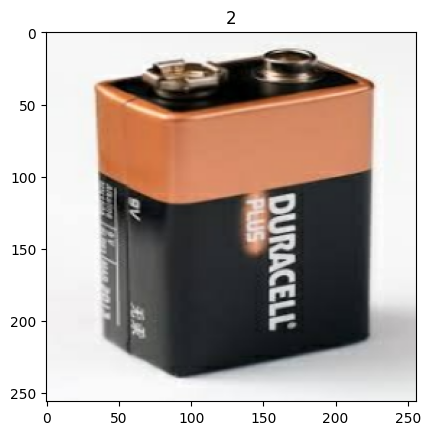

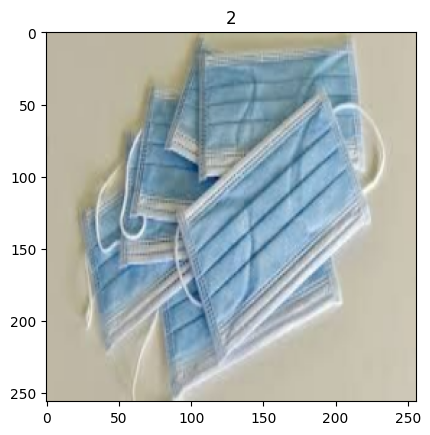

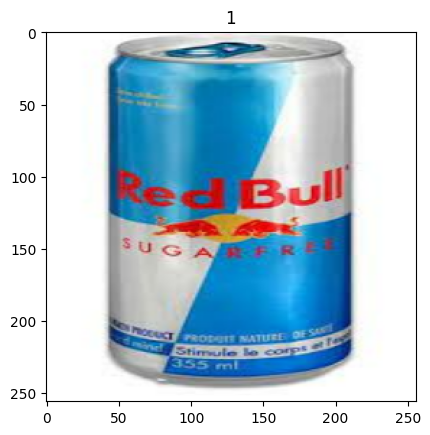

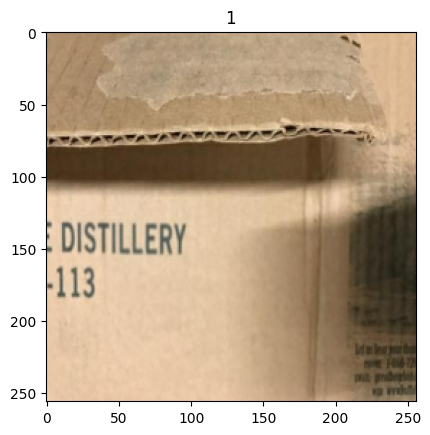

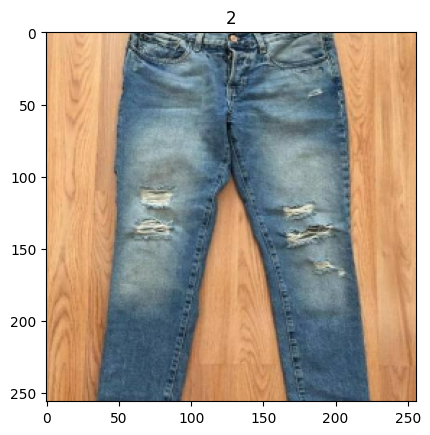

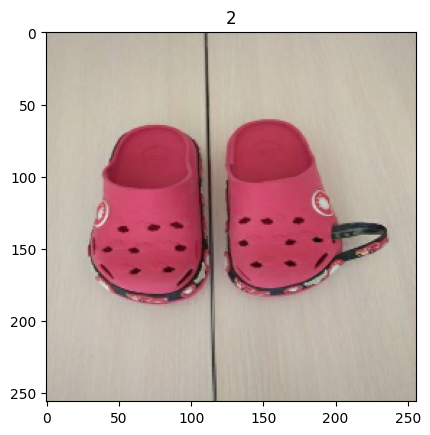

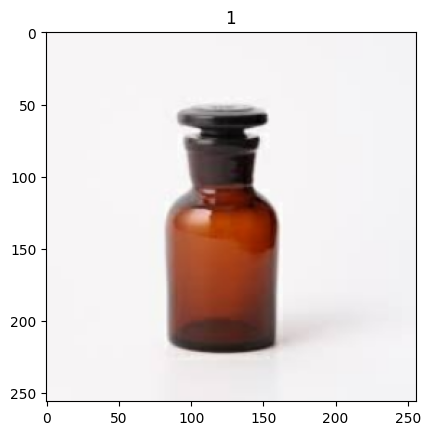

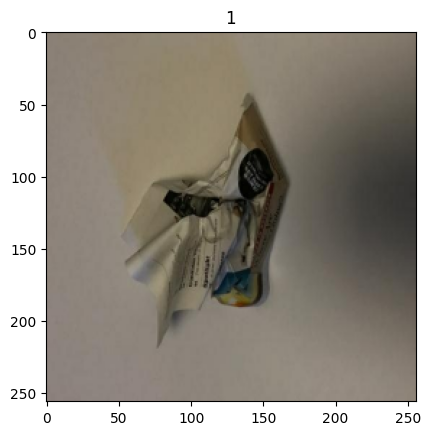

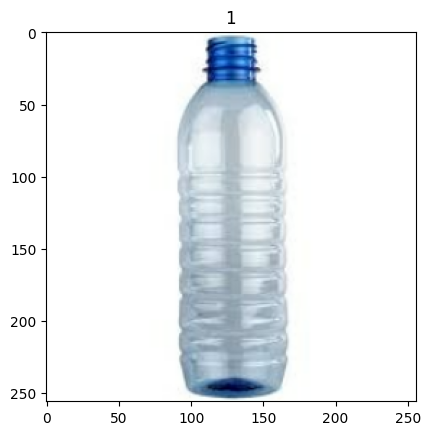

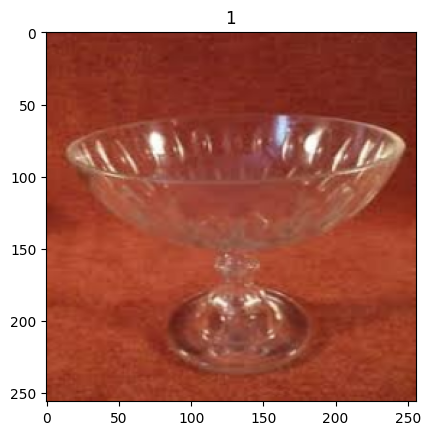

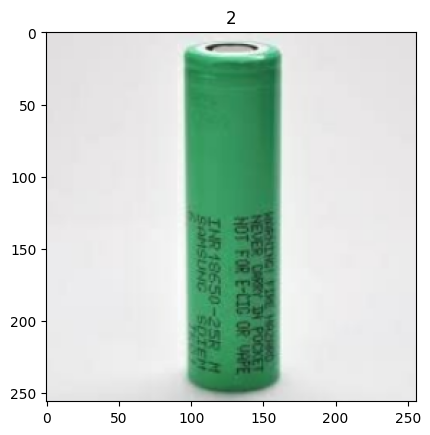

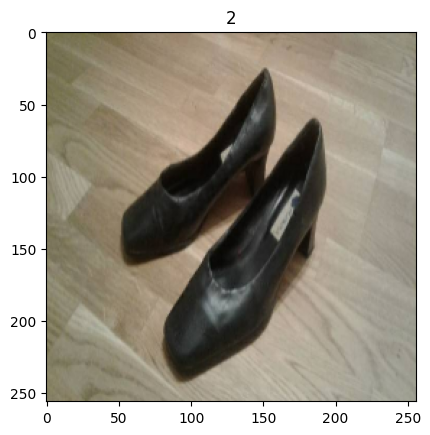

In [ ]:
for i, image in enumerate(batch[0]):
  plt.imshow(image)
  plt.title(batch[1][i])
  plt.show()

In [ ]:
data = data.map(lambda x,y: (x/255, y))

## Data Split

In [ ]:
train_size = int(round(len(data)*.6,0))
val_size = int(round(len(data)*.2,0))
test_size = int(round(len(data)*.2,0))

In [ ]:
val = data.take(val_size)
train = data.skip(val_size).take(train_size)
test = data.skip(train_size+val_size).take(test_size)

In [ ]:
y_train = np.concatenate([y for x, y in train], axis=0)
y_val = np.concatenate([y for x, y in val], axis=0)
y_test = np.concatenate([y for x, y in test], axis=0)

## CNN Model

In [ ]:
np.random.seed(1337) 
inputs = Input(shape=(256, 256, 3))

m = Conv2D(16, (3, 3), activation='relu')(inputs) 
m = MaxPooling2D(2, 2)(m)
m = Conv2D(32, (3, 3), activation='relu')(m)
m = MaxPooling2D(2, 2)(m)
m = Conv2D(64, (3, 3), activation='relu')(m)
m = Conv2D(64, (3, 3), activation='relu')(m)
m = MaxPooling2D(2, 2)(m)
m = Conv2D(128, (3, 3), activation='relu')(m)
m = Conv2D(128, (3, 3), activation='relu')(m)
m = MaxPooling2D(2, 2)(m)
m = Conv2D(256, (3, 3), activation='relu')(m)
m = Conv2D(256, (3, 3), activation='relu')(m)
m = Conv2D(256, (3, 3), activation='relu')(m)
m = MaxPooling2D(2, 2)(m)
m = Flatten()(m)
m = Dense(512, activation='relu')(m)
m = Dense(512, activation='relu')(m)
fm = Dense(num_class, activation='softmax')(m)

sub_model = Model(inputs=inputs, outputs=m)
cnn_model = Model(inputs=inputs, outputs=fm)

In [ ]:
adam = Adam(lr=1e-4)

cnn_model.compile(optimizer=adam,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

hist = cnn_model.fit(train, epochs=20, validation_data = val)
loss, accuracy = cnn_model.evaluate(test)

print('\ntest loss: ', loss)
print('\ntest accuracy: ', accuracy)

Epoch 1/20
305/305 [==============================] - 67s 184ms/step - loss: 0.7874 - accuracy: 0.5974 - val_loss: 0.6592 - val_accuracy: 0.7068
Epoch 2/20
305/305 [==============================] - 66s 188ms/step - loss: 0.6478 - accuracy: 0.6988 - val_loss: 0.6602 - val_accuracy: 0.6982
Epoch 3/20
305/305 [==============================] - 65s 186ms/step - loss: 0.5838 - accuracy: 0.7424 - val_loss: 0.5635 - val_accuracy: 0.7531
Epoch 4/20
305/305 [==============================] - 56s 151ms/step - loss: 0.5432 - accuracy: 0.7575 - val_loss: 0.5245 - val_accuracy: 0.7583
Epoch 5/20
305/305 [==============================] - 57s 154ms/step - loss: 0.5054 - accuracy: 0.7753 - val_loss: 0.4975 - val_accuracy: 0.7803
Epoch 6/20
305/305 [==============================] - 56s 152ms/step - loss: 0.4659 - accuracy: 0.7956 - val_loss: 0.5296 - val_accuracy: 0.7776
Epoch 7/20
305/305 [==============================] - 55s 152ms/step - loss: 0.4355 - accuracy: 0.8153 - val_loss: 0.4546 - val_ac

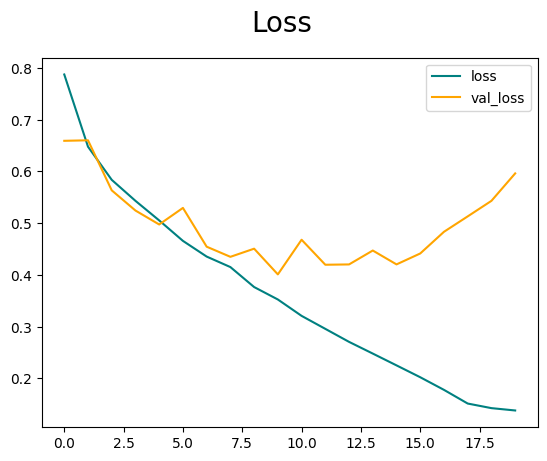

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

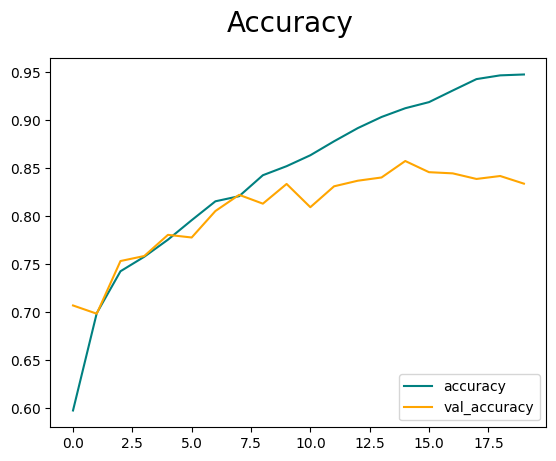

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="lower right")
plt.show()

In [ ]:
sub_model.save('/content/CNN_FinalDense_FD512.h5')
cnn_model.save('/content/CNN_3Class_FD512.h5')

In [ ]:
files.download('CNN_3Class_FD512.h5')
files.download('CNN_FinalDense_FD512.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Taking Final Dense Layer to Use in Different Models

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
train_xg = sub_model.predict(train)
val_xg = sub_model.predict(val)
test_xg = sub_model.predict(test)

101/101 [==============================] - 46s 96ms/step


In [ ]:
train_xg.shape, val_xg.shape, test_xg.shape

((9760, 512), (3264, 512), (3210, 512))

In [ ]:
z = np.concatenate([np.array(train_xg).reshape(train_xg.shape[0],train_xg.shape[1]),np.array(y_train).reshape(train_xg.shape[0],1)],axis=1)
z = pd.DataFrame(z)
z.to_csv('train_xg.csv',index=False)

z = np.concatenate([np.array(val_xg).reshape(val_xg.shape[0],val_xg.shape[1]),np.array(y_val).reshape(val_xg.shape[0],1)],axis=1)
z = pd.DataFrame(z)
z.to_csv('val_xg.csv',index=False)

z = np.concatenate([np.array(test_xg).reshape(test_xg.shape[0],test_xg.shape[1]),np.array(y_test).reshape(test_xg.shape[0],1)],axis=1)
z = pd.DataFrame(z)
z.to_csv('test_xg.csv',index=False)

In [ ]:
files.download('train_xg.csv')
files.download('val_xg.csv')
files.download('test_xg.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## CNN Predicts

Saving images15.jpg to images15 (1).jpg


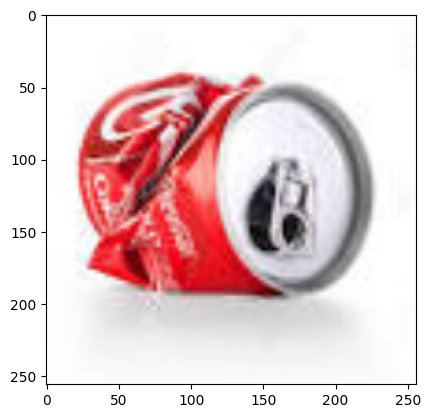

1/1 [==============================] - 0s 22ms/step


'recyc'

In [ ]:
predict_dict = {0: 'comp',
                1: 'recyc',
                2: 'trash'}

uploaded = files.upload()
f_name = [str(key) for key in uploaded.keys()][0]

img = cv2.imread(f'/content/{f_name}')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

yhat = cnn_model.predict(np.expand_dims(resize/255, 0))

predict_dict[int(np.argmax(yhat, axis = 1))]